In [67]:
using GpABC, Distances, Distributions, Plots, StatsBase, Printf
using DiffEqCallbacks, DifferentialEquations, LinearAlgebra
using DelimitedFiles, DataFrames, LinearAlgebra, SparseArrays


In [140]:
include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_model.jl");
include("/home/callum/ASF/Modules/ASF_analysis.jl")

Main.ASF_Analysis

In [141]:
input_path = "/home/callum/ASF/Inputs//";

# Model

In [143]:

input = ASF_Inputs.Model_Data(input_path, true);

┌ Info: Running with seasons
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:53
┌ Info: Barabasi Albert Scale Free Network
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:57
┌ Warning: Death probability of 0.9
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:164
┌ Warning: Intra-group transmission of 0.4
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:168
┌ Warning: Inter-group transmission of 0.01
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:172
┌ Warning: Corpse infectivity of 0.7
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:176
┌ Info: 1000 Feral Groups
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:370
┌ Info: 0 Farm Populations
└ @ Main.ASF_Inputs /home/callum/ASF/Modules/ASF_input.jl:371


In [121]:
input.Parameters.sd/4

1-element Vector{Float64}:
 15.0

In [109]:
a  =3

for i in 1:a
    if i == a
        println(4)
    end
end

4


In [107]:
input.Parameters.λ

1000-element Vector{Float32}:
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
  ⋮
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0
 80.0

In [ ]:
function asf_model_one(out,u,p,t)
    #ASF model for a single population (can make some speed increases) without farms!

    ref_density = 1 #baseline density (from Baltics where modelled was fitted)
    offset = 180 #seeding in the summer!
    year = 365 #days in a year

    u[u.<0] .= 0
    
    S = Vector{UInt8}(u[1:5:end])
    E = Vector{UInt8}(u[2:5:end])
    I = Vector{UInt8}(u[3:5:end])
    R = Vector{UInt8}(u[4:5:end])
    C = Vector{UInt8}(u[5:5:end])
    

    N = S .+ E .+ I .+ R .+ C
    Np = S .+ E .+ I .+ R
    
    N[N .== 0] .= 1
    
    tg = Pops.cum_sum[end] #total groups in all populations
    tp = sum(Np) # total living pigs


    beta = copy( β)
    μ_bb = copy( μ_b)
    μ_dd = copy( μ_d)
    Lambda = copy( λ)

   
    
    Density = tp/Pops.area[1]

    beta[ β_d .== i] .*= Density/ref_density

    if  Seasonal
    
        day = mod(t+offset, year)

        start =  sd[1]
        len =  l[1]
        ratio =  bs[1]

        s_offset =  so[1]
        s_amp =  as[i]

        if   sd[1] <= day <=  sd[1] +  l[1]
            ratiob = year*  bs[1]/ l[1]
            
            μ_bb .*= ratiob
            μ_dd .*= ratiob
                
        else
            ratiob = year*(1-  bs[1])/(year- l[1])
            
            μ_bb .*= ratiob
            μ_dd .*= ratiob
        
        end

        Lambda .+=  as[1] * cos((t +  so[1] .+ s_offset) * 2*pi/year)

    end

    v = ones(Int8,tp)
    
    populations  = v*N'+ N*v'
   
    populations[diagind(populations)] = N

    connected_pops =  β_b * Np
    
    #Setting base births
    Births = μ_bb.*Np
    
    #Immigration births
    mask_im = (Np .== 0) .& (connected_pops .>1) #population zero but connected groups have 1 or more pigs
    Births[mask_im] .= 2*μ_bb[mask_im]
    total_im = sum(2*μ_bb[mask_im])
    
    #Need to stop boars giving birth!
    mask_boar = ( μ_c .== 1) .& (Np .> 0) #population greater than 0 but carrying 1
    Births[mask_boar] .= 0 #Dont want these births!
    total_boar = sum(μ_bb[mask_boar].*Np[mask_boar]) #amount of births we have removed
    
    #now we need to adjust for immigration and boar births in the rest of the population
    mask_sow = (Np .> 0) .& ( μ_c .!= 1) #groups with pigs that are not boars!
    Births[mask_sow] .= Births[mask_sow] .+ (total_boar-total_im)/length(Births[mask_sow])
    
    out[1:11:end] .= Births
    out[2:11:end] .= S.*(μ_dd) .+ dense_deaths(μ_bb, μ_dd, p, S, Np)
    out[3:11:end] .= ((beta .* S) ./ populations) * (I +  ω .* C)
    out[4:11:end] .= E.*(μ_dd) .+ dense_deaths(μ_bb, μ_dd, p, E, Np)
    out[5:11:end] .=  ζ .* E
    out[6:11:end] .=  ρ .*  γ .* I 
    out[7:11:end] .= I.*(μ_dd) .+ dense_deaths(μ_bb, μ_dd, p, I, Np)
    out[8:11:end] .=  γ .* (1 .-  ρ) .* I
    out[9:11:end] .= R.*(μ_dd) .+ dense_deaths(μ_bb, μ_dd, p, R, Np)
    out[10:11:end].= (1 ./ Lambda) .* C
    out[11:11:end] .=  κ .* R 
    
    nothing
end

In [146]:

N_years = 5

rj = RegularJump(ASF_Model.asf_model_full,regular_c,eqs*nt)

jumps = JumpSet(rj)

prob = DiscreteProblem(input.U0, input.Time,input.Parameters)

jump_prob = JumpProblem(prob,Direct(),rj) #rng=rng)

sol = solve(jump_prob, SimpleTauLeaping(),dt=1)
#ensemble_prob_m = EnsembleProblem(jump_prob)#,prob_func=prob_func)


retcode: Default
Interpolation: Piecewise constant interpolation
t: 0.0f0:1.0f0:1825.0f0
u: 1826-element Vector{Vector{Int16}}:
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 21, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 21, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 21, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  20, 0, 0, 0, 0, 20, 0, 0, 0, 0]
 

In [126]:
a = [1,2,3,4,5]
b= [1,2,34,5,5]

5-element Vector{Int64}:
  1
  2
 34
  5
  5

In [127]:
b-a

5-element Vector{Int64}:
  0
  0
 31
  1
  0

In [88]:
nt = input_1.Parameters.Populations.cum_sum[end] #total number of groups and farms
nc = 5 #number of classes
eqs = 11 #number of processes
n_ens = 100 #number of runs in ensemble

dc = sparse(zeros(nt*nc,nt*eqs))

#const _dc = zeros(nt*5,nt*10)

dc[0*nc*nt+1:nc*nt*eqs+nc:end] .= 1
dc[1*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[2*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+1:nc*nt*eqs+nc:end] .= 1

dc[2*nc*nt+2:nc*nt*eqs+nc:end] .= 1
dc[3*nc*nt+2:nc*nt*eqs+nc:end] .= -1
dc[4*nc*nt+2:nc*nt*eqs+nc:end] .= -1

dc[4*nc*nt+3:nc*nt*eqs+nc:end] .= 1
dc[5*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[6*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[7*nc*nt+3:nc*nt*eqs+nc:end] .= -1

dc[7*nc*nt+4:nc*nt*eqs+nc:end] .= 1
dc[8*nc*nt+4:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+4:nc*nt*eqs+nc:end] .= -1


dc[5*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[6*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[9*nc*nt+5:nc*nt*eqs+nc:end] .= -1;

In [21]:
pwd()

"/home/callum/ASF"

In [89]:
function regular_c(du,u,p,t,counts,mark)  
    mul!(du,dc,counts)
    nothing
end

regular_c (generic function with 1 method)

In [23]:
function convert(input)
    
    params = Vector{Any}(undef,13)
    
    params[1]  = copy(input.β)
    params[2]  = copy(input.β_b)
    params[3]  = copy(input.β_d)
    
    params[4]  = copy(input.μ_b)
    params[5]  = copy(input.μ_d)
    params[6]  = copy(input.μ_c)
    
    params[7]  = copy(input.ζ)
    params[8]  = copy(input.γ)
    params[9]  = copy(input.ω)
    params[10] = copy(input.ρ)
    params[11] = copy(input.λ)
    params[12] = copy(input.κ)
    
    #params[13] = copy(input.Populations)
    params[13] = 6.46
    return params
    
end

convert (generic function with 1 method)

In [24]:
function g2__(a,U,N,k,r)
    dummy = r*U
     
    dummy[N .>k] .+= (a*r).*(N[N.>k]-k[N.>k]).^(1/2).*(U[N.>k]./N[N.>k])
    
    
    dummy[0 .< N .< k ] .= -r*U[0 .< N .< k ].*(N[0 .< N .< k ]./k[0 .< N .< k ])
    
    return dummy
end

g2__ (generic function with 1 method)

In [25]:
dens = (0:2000) ./1000;
kd = 1;
beta = 0.5;

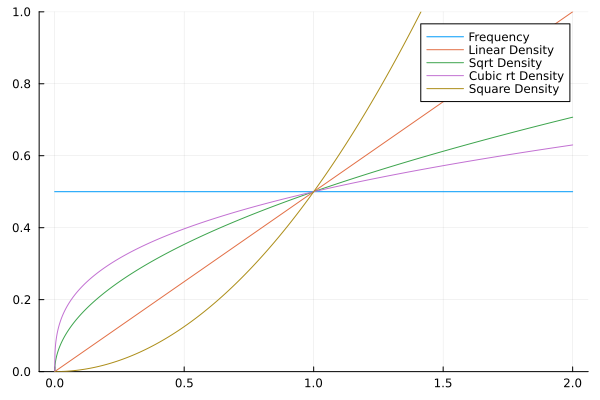

In [26]:
plot(dens,0*dens.+beta, label= "Frequency")
plot!(dens,dens/kd*beta, label = "Linear Density")
plot!(dens,beta*(dens/kd).^(1/2), label = "Sqrt Density")
plot!(dens,beta*(dens/kd).^(1/3), label = "Cubic rt Density")
plot!(dens,beta*(dens/kd).^(2), ylims=(0,1), label = "Square Density")


In [27]:
plot(x,y)

LoadError: UndefVarError: x not defined

: 

In [8]:
a = zeros(10,10)
a[1,1] = 1
a

10×10 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [14]:
using CSV

In [15]:
seasonal_data = CSV.read("$(input_path)/Seasonal/Seasonal_$(1).csv", DataFrame; comment="#") 
searchsorted

Row,Name,Value
,String15,Float64
1,Birth_split,0.75
2,Birth_length,100.0
3,Birth_start,60.0
4,Decay_amp,20.0
5,Decay_offset,0.0


In [16]:
seasonal_data.Value[1]

0.75

In [ ]:
function asf_update(out,u,p,t)
    
    β, β_b, β_d, μ_b, μ_d, μ_c, ζ, γ, ω, ρ, λ, κ,a = p
    
    u[u.<0] .= 0
    
    S = Vector{UInt8}(u[1:5:end])
    E = Vector{UInt8}(u[2:5:end])
    I = Vector{UInt8}(u[3:5:end])
    R = Vector{UInt8}(u[4:5:end])
    C = Vector{UInt8}(u[5:5:end])
    
    tp = length(S)
    N = S .+ E .+ I .+ R .+ C
    Np = S .+ E .+ I .+ R
    
    N[N .== 0] .= 1
    
    v = ones(Int8,tp)

    populations  = v*N'+ N*v'
    populations[diagind(populations)] = N;
    

    ββ = sparse(copy(β))
    
    Density = tp/sum(μ_c)
    ββ[β_d .== 1] .*= ((Density/1).^(1/2))
    
    μ_bb = copy(μ_b)
    μ_dd = copy(μ_d)
    

    split = .75
    offset = 180
    year = 365
    high = 100
    high_start = 60

    if seasons ==  true
        
        day = mod(t+offset, year)
        #will have 3 seasons

        if  high_start <= day <= high+high_start
            ratiob = year*split/high
            
            μ_bb .*= ratiob
            μ_dd .*= ratiob
            #beta[β_d .== 1] .*= 1/2
            
        else
            ratiob = year*(1-split)/(year-high)
            
            μ_bb .*= ratiob
            μ_dd .*= ratiob
        
            #beta[β_d .== 1] .*= 3/2
        end
    end
    
    connected_pops = β_b * Np
    
    #Setting base births
    Births = μ_bb.*Np
    
    #Immigration births
    mask_im = (Np .== 0) .& (connected_pops .>1) #population zero but connected groups have 1 or more pigs
    Births[mask_im] .= 2*μ_bb[mask_im]
    total_im = sum(2*μ_bb[mask_im])
    
    #Need to stop boars giving birth!
    mask_boar = (μ_c .== 1) .& (Np .> 0) #population greater than 0 but carrying 1
    Births[mask_boar] .= 0 #Dont want these births!
    total_boar = sum(μ_bb[mask_boar].*Np[mask_boar]) #amount of births we have removed
    
    #now we need to adjust for immigration and boar births in the rest of the population
    mask_sow = (Np .> 0) .& (μ_c .!= 1) #groups with pigs that are not boars!
    Births[mask_sow] .= Births[mask_sow] .+ (total_boar-total_im)/length(Births[mask_sow])
    g_eff  = (Np.^2)./(μ_c.^2).*([1]-μ_dd[1])
    
    out[1:11:end] .= Births
    out[2:11:end] .= S.*(μ_dd) .+ g2__(a,S, N,μ_c,(μ_bb[1]-μ_dd[1]))
    out[3:11:end] .= ((ββ .* S) ./ populations) * (I + ω .* C)
    out[4:11:end] .= E.*(μ_dd) .+ g2__(a,E, N,μ_c,(μ_bb[1]-μ_dd[1]))
    out[5:11:end] .= ζ .* E
    out[6:11:end] .= ρ .* γ .* I 
    out[7:11:end] .= I.*(μ_dd) .+ g2__(a,I, N,μ_c,(μ_bb[1]-μ_dd[1]))
    out[8:11:end] .= γ .* (1 .- ρ) .* I
    out[9:11:end] .= R.*(μ_dd) .+ g2__(a,R, N,μ_c,(μ_bb[1]-μ_dd[1]))
    out[10:11:end].= (1/(80 +20*cos((t+offset)*2*pi/year))) .* C
    out[11:11:end] .= κ .* R 
    
    nothing
end

asf_update (generic function with 1 method)

# Model Running Fitting


In [19]:
Vector{UInt8}(0, 10)

LoadError: MethodError: no method matching Vector{UInt8}(::Int64, ::Int64)
[0mClosest candidates are:
[0m  Vector{T}([91m::UndefInitializer[39m, ::Int64) where T at boot.jl:448
[0m  Array{T, N}([91m::UndefInitializer[39m, ::Int64...) where {T, N} at boot.jl:454
[0m  Vector{T}([91m::UndefInitializer[39m, ::Integer) where T at baseext.jl:12
[0m  ...

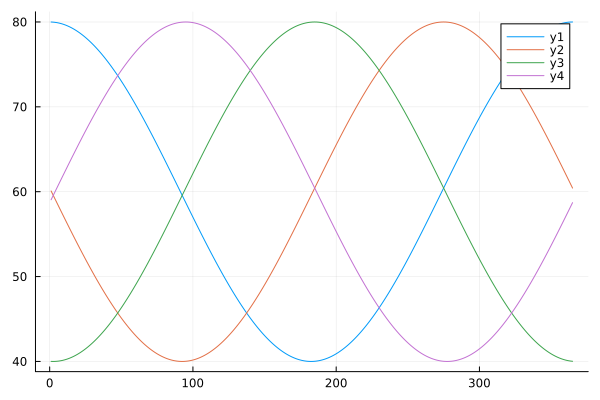

In [53]:
t = 1:1:365
y = 60 .+ 20 .* cos.((t) * 2*pi/365);
ys = 60 .+ 20 .* cos.((t.+90) * 2*pi/365);
yi = 60 .+ 20 .* cos.((t.+180) * 2*pi/365);
yii = 60 .+ 20 .* cos.((t.+270) * 2*pi/365);

plot(t,y)
plot!(t,ys)
plot!(t,yi)
plot!(t,yii)


In [ ]:
60 .+ 20 .* cos.((t .+ (offset + 5)) * 2*pi/year)

In [ ]:
function run_analysis(sol)

    data = reduce(vcat,transpose.(sol.u))
    data[data .< 0 ] .= 0


    s_d = data[:,1:5:end]
    e_d = data[:,2:5:end]
    i_d = data[:,3:5:end]
    r_d = data[:,4:5:end]
    c_d = data[:,5:5:end]

    disease_total = e_d + i_d + c_d #classes with disease
    disease_alive = e_d + i_d

    disease_free = s_d + r_d #classes without disease

    disease_sum = sum(disease_total,dims=2)
    disease_alive_sum =  sum(disease_alive,dims=2)
    disease_free_sum = sum(disease_free,dims=2)
    population_sum = disease_alive_sum + disease_free_sum;
    
    return disease_sum, disease_alive_sum, disease_free_sum, population_sum
end



run_analysis (generic function with 1 method)

In [ ]:
function plot_ou(data)
s = 0
ep = 0
mt = 0
pd = 0
for i in 1:n_runs
    d, da,f,p = run_analysis(data[i])
    
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[2*365:end])
        pd += 100*(1-mean(p[3*365:end])/p[1])
        mt += maximum(findall(==(maximum(d)), d))[1]
        
        
        s += 1
    end

end
println("Endemic Runs: ", s)
println("Endemic Prev: ", ep/s)
println("Peak Time: ", mt/s)
println("Pop Decline: ", pd/s)
end

In [ ]:
seasons = true

true

In [ ]:
n_runs = 3
n_years = 7

7

In [ ]:
input_1 = ASF_Inputs.Model_Data(input_path);
pp = convert(input_1.Parameters);

 Barabasi Albert Scale Free Network


In [ ]:
rj = RegularJump(asf_update, regular_c, eqs*nt)
prob = DiscreteProblem(input_1.U0,(0.0,365*n_years),pp)
jump_prob = JumpProblem(prob,Direct(),rj)
#sol = solve(jump_prob, SimpleTauLeaping(), dt= 1)
ensemble_prob_m = EnsembleProblem(jump_prob)
outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

Endemic Runs: 2
Endemic Prev: 0.7051174609154283
Peak Time: 311.0
Pop Decline: 78.40413660619286


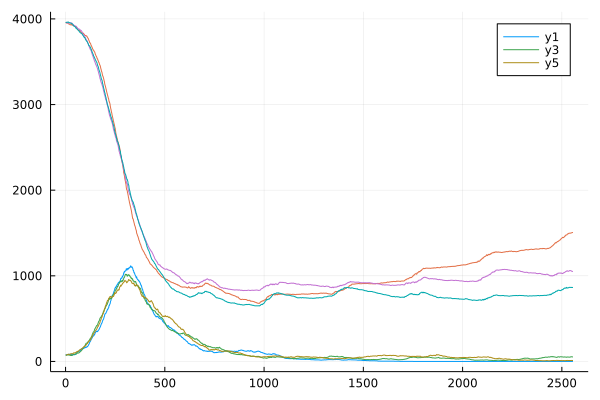

In [123]:
plot()
s = 0
ep = 0
mt = 0
pd = 0
for i in 1:n_runs
    d, da,f,p = run_analysis(outputs[i])
    
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[2*365:end])
        pd += 100*(1-mean(p[3*365:end])/p[1])
        mt += maximum(findall(==(maximum(d)), d))[1]
        
        
        s += 1
    end
    plot!(d, laebl = "")
    plot!(f, label = "")
end
println("Endemic Runs: ", s)
println("Endemic Prev: ", ep/s)
println("Peak Time: ", mt/s)
println("Pop Decline: ", pd/s)

plot!()

# Population Fitting


In [ ]:
AUSASF2 = function(params,Tspan, U0,A)
    
    rj = RegularJump(asf_update, regular_c, eqs*nt)
    prob = DiscreteProblem(U0,Tspan,params)
    jump_prob = JumpProblem(prob,Direct(),rj)
    #sol = solve(jump_prob, SimpleTauLeaping(), dt= 1)
    ensemble_prob_m = EnsembleProblem(jump_prob)
    outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);
    res = eval_out2(outputs,U0,A)
    return res
end
    

In [ ]:
function simulator_function2(var_params)
    Tspan = (0.0,365*n_years)
    input_1 = ASF_Inputs.Model_Data(input_path);

    U0 = copy(input_1.U0);
    U0[1:5:end] += (U0[2:5:end] +U0[3:5:end])
    U0[2:5:end] .= 0
    U0[3:5:end] .= 0;
    
    params = convert(input_1.Parameters)
    
    params[13] = var_params[1] #corpse decay rates
    
    #now we run simulation!
    AUSASF2(params, Tspan, U0,A)
end

In [ ]:
function eval_out2(output, U0,A)
    output_final = Matrix{Float64}(undef,(3651,1))
    dist = zeros(Float64,n_runs)
    K = sum(U0)
   dummy = zeros(3651)
    
    for i = 1:n_runs
        sol = output[i]
        data = reduce(vcat,transpose.(sol.u))
        data[data .< 0 ] .= 0

        s_d = data[:,1:5:end]
        
        pop_sum = sum(s_d,dims=2)[:,1]
        
        pop_crop = pop_sum/K
 
        dummy += pop_crop/n_runs
        
    
    end
    output_final[:] = dummy
    dist = euclidean(obs[:],dummy)
    if euclidean(obs[:],dummy) < threshold
        A += 1
        println(A)
    end
    return output_final
    
end

In [ ]:
function observed_params()
   
    obs =  Matrix{Float64}(undef,(3651,1))
    
    obs .= 1
    
    return obs
end

obs = observed_params();

In [ ]:
priors = [Uniform(5, 8)]

In [ ]:
n_particles = 100
threshold = sqrt(3651((1-0.99)^2))
sim_result = SimulatedABCRejection(obs, simulator_function2, priors, threshold, n_particles; max_iter=1000, write_progress=false)#,

In [ ]:
plot(sim_result)

# ASF Fitting


In [97]:
seasons = true

true

In [101]:
n_years = 7
n_runs  = 3
n_con = 8

8

In [103]:
function ASF_Model_ABC(dis_params,Tspan,U0)
     rj = RegularJump(asf_update, regular_c, eqs*nt)
    prob = DiscreteProblem(U0,Tspan,dis_params)
    jump_prob = JumpProblem(prob,Direct(),rj)
    ensemble_prob = EnsembleProblem(jump_prob)
    model_outs = solve(ensemble_prob, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1)
    res = eval_outss(model_outs)
end
    

ASF_Model_ABC (generic function with 1 method)

In [104]:
function simulator_function(var_params)

    Tspan = (0.0,365*n_years)
    
    input_1 = ASF_Inputs.Model_Data(input_path);
    U0 = input_1.U0
    params = convert(input_1.Parameters)
 
    #beta
    params[1][diagind(params[1])] .= var_params[1] #intra
    params[1][params[2] .== 1 ] .= var_params[2]/n_con #inter
    
    
    #corpse 
    params[9] .= var_params[3] #corpse infection modifier
    #params[11] .= var_params[4] #corpse decay rates
     
    #now we run simulation!
    ASF_Model_ABC(params, Tspan, U0)
end

simulator_function (generic function with 1 method)

In [105]:
function eval_outss(data) 
    
    output_final = Matrix{Float64}(undef,(3,1))
    s = 0
    ep = 0
    mt = 0
    pd = 0
    
    for i in 1:3
    d, da,f,p = run_analysis(data[i])

    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
        pd += 100*(1-mean(p[3*365:end])/p[1])
        mt += maximum(findall(==(maximum(d)), d))[1]


        s += 1
    end

    end
    
    
    if s >= 2
        output_final[1] = ep/s*(1/2)
        output_final[2] = pd/s*(1/10)
        output_final[3] = mt/s*(2/365)
        
    else
        output_final[1] = 0
        output_final[2] = 0
        output_final[3] = 0
    end
    
    d= euclidean(output_final,obs)
    if d < threshold
        println(d)
    end

    return output_final
    
end

eval_outss (generic function with 1 method)

In [124]:
function observed_params()
   
    obs =  Matrix{Float64}(undef,(3,1))
    
    obs[1] = 1 #2 #endemic prev
    obs[2] = 8#80 #population delcine %
    obs[3] = 2#180 #time (days) from init to max
    
    return obs
end

obs = observed_params();

In [125]:
priors = [Uniform(0.15, 0.85), Uniform(0.015, 0.085), Uniform(0.15, 1)]

3-element Vector{Uniform{Float64}}:
 Uniform{Float64}(a=0.15, b=0.85)
 Uniform{Float64}(a=0.015, b=0.085)
 Uniform{Float64}(a=0.15, b=1.0)

In [ ]:
n_particles = 100
threshold = 1.0
sim_result = SimulatedABCRejection(obs, simulator_function, priors, threshold, n_particles; max_iter=5000, write_progress=false)#,

In [131]:
#
# ABC-SMC settings
#
threshold_schedule = [1, 0.8, 0.7];

In [ ]:
n_particles = 100;


 Barabasi Albert Scale Free Network
0.8345625521343073
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
0.6730469072204714
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
0.7518979537092709
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
0.8693602932430055
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
0.8830228321136694
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
 Barabasi Albert Scale Free Network
0.984

In [130]:
plot(sim_abcsmc_res)

LoadError: UndefVarError: sim_abcsmc_res not defined

In [ ]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]

In [ ]:
data = sim_abcsmc_res.population[2]

In [ ]:
for i = 1:4
    println()
    println(median(data[:,i]))
    println(mean(data[:,i]))
end